In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
import statsmodels.api as sm


In [23]:
data = pd.read_excel(os.getcwd() + "/data/ODMD_MainData.xlsx")
data = data.sort_values(ascending=True,by="Date")
data.loc[data.MARKA == "KG MOBILITY – SSANGYONG",'MARKA'] = "SSANGYONG" 
## 0 olan satıs aylarını cıkar.
data = data[data.TTL_TOPLAM != 0]

## group by Date
monthly_data = data[["Date","TTL_TOPLAM"]].groupby("Date").agg({"TTL_TOPLAM":"sum"}).reset_index()
monthly_data.head(5)

,Date,TTL_TOPLAM
0,2014-01-01,32670
1,2014-02-01,35021
2,2014-03-01,47581
3,2014-04-01,53305
4,2014-05-01,58121


In [24]:
monthly_data = monthly_data.sort_values("Date",ascending= True)
monthly_data

,Date,TTL_TOPLAM
0,2014-01-01,32670
1,2014-02-01,35021
2,2014-03-01,47581
3,2014-04-01,53305
4,2014-05-01,58121
...,...,...
122,2024-03-01,109828
123,2024-04-01,75919
124,2024-05-01,100305
125,2024-06-01,106238


In [27]:
## Shift & MA
monthly_data["Shifted1"] = monthly_data["TTL_TOPLAM"].shift(1)
monthly_data["Shifted3"] = monthly_data["TTL_TOPLAM"].shift(3)
monthly_data["Shifted6"] = monthly_data["TTL_TOPLAM"].shift(6)
monthly_data["Shifted12"] = monthly_data["TTL_TOPLAM"].shift(12)
monthly_data["Shifted1_SMA3"] = monthly_data["TTL_TOPLAM"].shift(1).rolling(3).mean()
monthly_data["Shifted1_SMA6"] = monthly_data["TTL_TOPLAM"].shift(1).rolling(6).mean()
monthly_data["Shifted1_SMA12"] = monthly_data["TTL_TOPLAM"].shift(1).rolling(12).mean()



## Date Features
monthly_data["Month"] = monthly_data.Date.dt.month
monthly_data["Quarter"] = monthly_data.Date.dt.quarter
monthly_data["Year"] = monthly_data.Date.dt.year

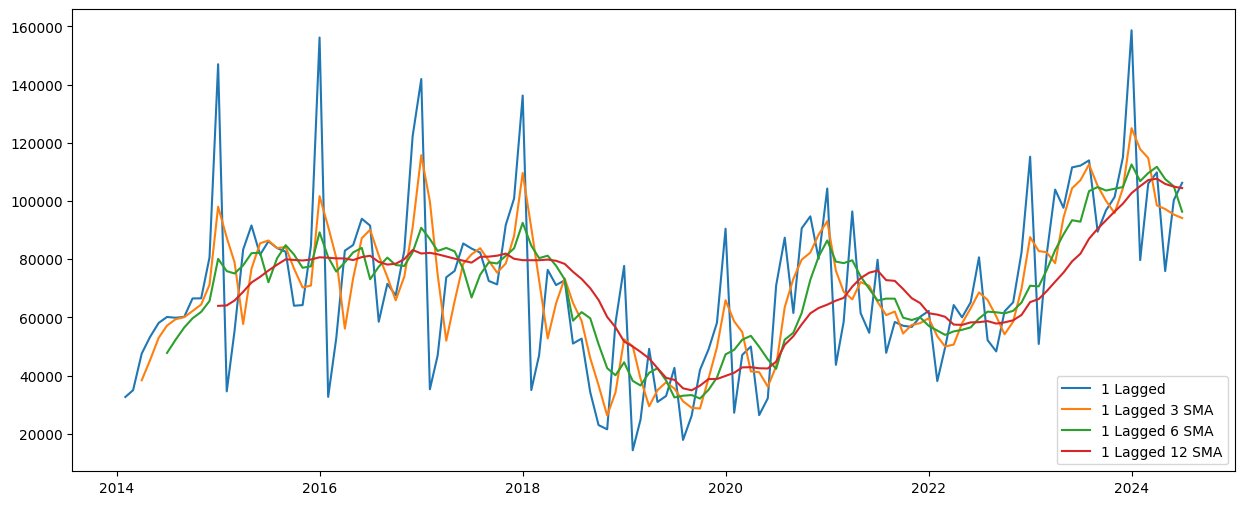

In [29]:
plt.figure(figsize=(15,6))
plt.plot(monthly_data["Date"],monthly_data["Shifted1"],label = "1 Lagged")
plt.plot(monthly_data["Date"],monthly_data["Shifted1_SMA3"],label = "1 Lagged 3 SMA")
plt.plot(monthly_data["Date"],monthly_data["Shifted1_SMA6"],label = "1 Lagged 6 SMA")
plt.plot(monthly_data["Date"],monthly_data["Shifted1_SMA12"],label = "1 Lagged 12 SMA")

plt.legend()
plt.show()

In [63]:
train_set = monthly_data[monthly_data.Date < '2023-11-01']
test_set = monthly_data[monthly_data.Date >= '2023-11-01']
X_Train = train_set.drop(["Date","TTL_TOPLAM"],axis = 1)
X_Test = test_set.drop(["Date","TTL_TOPLAM"],axis = 1)
y_train = train_set["TTL_TOPLAM"]
y_test = test_set["TTL_TOPLAM"]

In [150]:
X_Train

,Shifted1,Shifted3,Shifted6,Shifted12,Shifted1_SMA3,Shifted1_SMA6,Month,Quarter,Year,Shifted1_SMA12
Date,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2014,NaN
2014-02-01,32670.0,NaN,NaN,NaN,NaN,NaN,2,1,2014,NaN
2014-03-01,35021.0,NaN,NaN,NaN,NaN,NaN,3,1,2014,NaN
2014-04-01,47581.0,32670.0,NaN,NaN,38424.000000,NaN,4,2,2014,NaN
2014-05-01,53305.0,35021.0,NaN,NaN,45302.333333,NaN,5,2,2014,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-06-01,111556.0,103929.0,115220.0,80652.0,104388.000000,93404.333333,6,2,2023,79269.750000
2023-07-01,112163.0,97679.0,50894.0,52206.0,107132.666667,92894.833333,7,3,2023,81895.666667
2023-08-01,113959.0,111556.0,81148.0,48336.0,112559.333333,103405.666667,8,3,2023,87041.750000


In [37]:
model = CatBoostRegressor().fit(X_Train, y_train)


y_pred = model.predict(X_Test)
mean_absolute_percentage_error(y_test, y_pred)

Learning rate set to 0.02921
0:	learn: 27303.6343102	total: 132ms	remaining: 2m 11s
1:	learn: 27022.6095712	total: 133ms	remaining: 1m 6s
2:	learn: 26697.9510819	total: 135ms	remaining: 44.8s
3:	learn: 26327.0018310	total: 136ms	remaining: 33.9s
4:	learn: 26012.7866869	total: 138ms	remaining: 27.4s
5:	learn: 25657.7323866	total: 139ms	remaining: 23s
6:	learn: 25344.1738148	total: 140ms	remaining: 19.8s
7:	learn: 25052.2438749	total: 140ms	remaining: 17.4s
8:	learn: 24794.9042942	total: 141ms	remaining: 15.5s
9:	learn: 24530.3952451	total: 142ms	remaining: 14.1s
10:	learn: 24308.4562413	total: 143ms	remaining: 12.9s
11:	learn: 24001.0623844	total: 144ms	remaining: 11.9s
12:	learn: 23716.5326263	total: 145ms	remaining: 11s
13:	learn: 23441.9284759	total: 145ms	remaining: 10.2s
14:	learn: 23129.1157034	total: 146ms	remaining: 9.59s
15:	learn: 22848.2183765	total: 147ms	remaining: 9.03s
16:	learn: 22577.2050129	total: 148ms	remaining: 8.53s
17:	learn: 22294.7374981	total: 148ms	remaining: 

0.16355656244197295

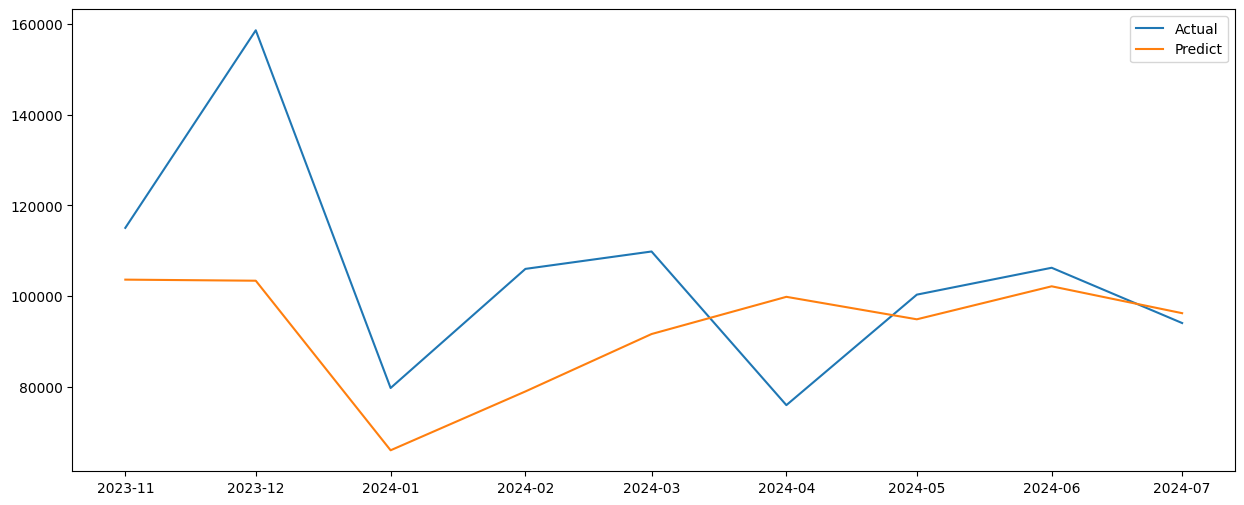

In [38]:
plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,y_pred,label = "Predict")
plt.legend()
plt.show()

In [80]:
X_Train = train_set.set_index("Date")
X_Test = test_set.set_index("Date")
y_train = X_Train["TTL_TOPLAM"]
y_test = X_Test["TTL_TOPLAM"]

X_Train = X_Train.drop("TTL_TOPLAM",axis=1)
X_Test = X_Test.drop("TTL_TOPLAM",axis=1)

In [144]:
arima = sm.tsa.statespace.SARIMAX(y_train,exog=X_Train.fillna(method="bfill"),order=(6,0,0),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=True, enforce_invertibility=True).fit()
arima.summary()


C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             TTL_TOPLAM   No. Observations:                  118
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -1309.904
Date:                Fri, 09 Aug 2024   AIC                           2653.807
Time:                        17:14:55   BIC                           2700.909
Sample:                    01-01-2014   HQIC                          2672.932
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Shifted1           0.2218      0.126      1.756      0.079      -0.026       0.469
Shifted3          -0.2592      0.184     -1.409      0.159      -0.620       0.101
Shifted6           0.3247      0.253      1.282      0.200      -0.172       0.821
Shifted12         -0.1273      0.184     -0.691      0.490      -0.488       0.234
Shifted1_SMA3     -0.0695      0.297     -0.234      0.815      -0.651       0.512
Shifted1_SMA6      0.9066      0.526      1.722      0.085      -0.125       1.938
Month           1.366e+04   3416.659      3.998      0.000    6964.343    2.04e+04
Quarter        -3.212e+04   1.23e+04     -2.617      0.009   -5.62e+04   -8067.919
Year               2.7528      7.014      0.393      0.695     -10.993      16.499
Shifted1_SMA12    -0.1876      0.393     -0.477      0.633      -0.958       0.582
ar.L1              0.0645      0.118      0.549      0.583      -0.166       0.295
ar.L2             -0.0004      0.116     -0.004      0.997      -0.227       0.226
ar.L3              0.1943      0.112      1.742      0.081      -0.024       0.413
ar.L4              0.1459      0.111      1.310      0.190      -0.072       0.364
ar.L5              0.1211      0.119      1.015      0.310      -0.113       0.355
ar.L6             -0.6143      0.162     -3.782      0.000      -0.933      -0.296
sigma2          3.042e+08      0.644   4.72e+08      0.000    3.04e+08    3.04e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.21   Prob(JB):                         0.44
Heteroskedasticity (H):               0.81   Skew:                             0.28
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.93e+24. Standard errors may be unstable.
"""

In [145]:
te_start,te_end = '2023-11-01','2024-07-01'

In [146]:
pred = arima.predict(te_start,te_end,exog = X_Test)


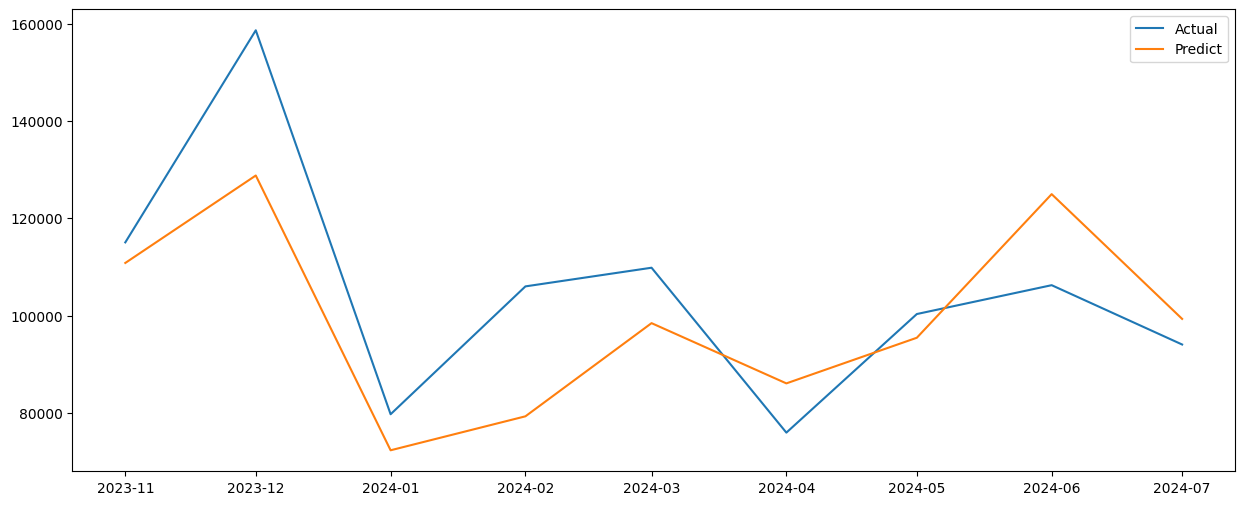

In [147]:
plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,pred,label = "Predict")
plt.legend()
plt.show()

In [148]:
mean_absolute_percentage_error(y_test,pred)

0.12089086658470599

In [149]:
mean_absolute_error(y_test,pred)

13178.368404506657